# Notebook de análise exploratória dos dados (EDA)

## Importação das bibliotecas

In [1]:
# Libs básicas
import pandas as pd
import numpy as np

# Libs Estatísticas
# Testar distribuição, assimetria, curtose e normalidade
from scipy.stats import skew, kurtosis, shapiro, normaltest, zscore 

# Libs de Vizualização
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Libs Serie Temporal
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [2]:
# Configurar paleta de cores e estilo

# Matplotlib
mpl.rcParams["figure.figsize"] = (20, 7)
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["font.size"] = 12
mpl.rcParams["figure.titlesize"] = 25
mpl.rcParams["figure.dpi"] = 100

# Seaborn
sns.set_style('whitegrid', {"grid.color": ".8", "grid.linestyle": "--"})
sns.set_palette(palette='mako')

## Aquisição dos dados

In [3]:
input_path = '../data/raw/dados_historicos_ibovespa_2008-2025.csv'

df = pd.read_csv(input_path, thousands='.', decimal=',', parse_dates=['Data'], date_format='%d.%m.%Y', index_col='Data')
df = df.rename_axis('ds').sort_index()
df.tail()

,Último,Abertura,Máxima,Mínima,Vol.,Var%
ds,,,,,,
2025-06-12,137800,137127,137931,136175,"7,12B","0,49%"
2025-06-13,137213,137800,137800,136586,"8,63B","-0,43%"
2025-06-16,139256,137212,139988,137212,"7,62B","1,49%"
2025-06-17,138840,139256,139497,138293,"8,38B","-0,30%"
2025-06-18,138717,138844,139161,138443,"8,32B","-0,09%"


# Limpeza e Renomeamento das Colunas

In [4]:
# informações gerais do dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4315 entries, 2008-01-18 to 2025-06-18
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Último    4315 non-null   int64 
 1   Abertura  4315 non-null   int64 
 2   Máxima    4315 non-null   int64 
 3   Mínima    4315 non-null   int64 
 4   Vol.      4314 non-null   object
 5   Var%      4315 non-null   object
dtypes: int64(4), object(2)
memory usage: 236.0+ KB


In [ ]:
# Tamanho do DataFrame
df.shape

(4315, 6)

In [6]:
# renomeando as colunas para os nomes padrões utilizados no mercado financeiro
colunas = {
  'Último': 'close',              # fechamento da negociação diária
  'Abertura': 'open',             # início da negociação diária
  'Máxima': 'high',               # valor máximo do dia
  'Mínima': 'low',                # valor mínimo do dia
  'Vol.': 'volume',               # volume de negociação diária
  'Var%': 'daily_return'          # variação percentual diária
}

df.rename(columns=colunas, inplace=True)

In [7]:
# Data mínima, máxima e total de anos do DF levando em conta os anos bissextos
print(f"Os dados vão de {df.index.min().date()} até {df.index.max().date()}, o que dá aproximadamente {(df.index.max() - df.index.min()).days / 365.25:.0f} anos")

Os dados vão de 2008-01-18 até 2025-06-18, o que dá aproximadamente 17 anos


In [ ]:
# Função para conversão do valores de volume
def converter_volume(vol: str | float) -> float:
    """
    Converte uma string de volume com sufixos (K, M, B) para um número float.
    
    Parâmetro:
        vol (string | float): o valor a ser convertido (ex: '8,3M'). Pode ser uma string ou um np.nan (que é float).
        
    Retorna:
        float: o valor convertido ou np.nan caso não haja um valor.
    """
    if not isinstance(vol, str):
        return vol

    multiplicadores = {'K': 1e3, 'M': 1e6, 'B': 1e9}
    vol = vol.upper().replace(',', '.').strip()
    sufixo = vol[-1]

    if sufixo in multiplicadores:
        return float(vol[:-1]) * multiplicadores[sufixo]
    else:
        return float(vol)

df['volume'] = df['volume'].apply(converter_volume)

In [ ]:
# Observa valores nulos
df.isnull().sum().sort_values(ascending=False)

volume          1
close           0
open            0
high            0
low             0
daily_return    0
dtype: int64

In [ ]:
# substituir o valor do volume nulo pela média do volume anterior e posterior daquela data
df['volume'] = df['volume'].interpolate().copy()

In [11]:
# Conferi se existem dados duplicados
(f'Dados duplicados: {df.duplicated().sum()}')

'Dados duplicados: 0'

In [ ]:
# Substiui caracteres da coluna daily_return
df['daily_return'] = df['daily_return'].str.replace('%', '').str.replace(',', '.')
df['daily_return'] = round(df['daily_return'].astype(float) / 100, 4)
df.head()

,close,open,high,low,volume,daily_return
ds,,,,,,
2008-01-18,57506,57039,58291,56241,5810000.0,0.0082
2008-01-21,53709,57503,57503,53487,3570000.0,-0.0660
2008-01-22,56097,53705,56541,53610,3650000.0,0.0445
2008-01-23,54235,56098,56098,53011,3720000.0,-0.0332
2008-01-24,57463,54242,57675,54242,3800000.0,0.0595


# Filtragem do periodo de negociação a partir de 2015

In [13]:
df_2015_2025 = df.loc[df.index > '2015-01-01'].copy()
df_2015_2025

,close,open,high,low,volume,daily_return
ds,,,,,,
2015-01-02,48512,50004,50004,48345,2.880000e+06,-0.0299
2015-01-05,47517,48512,48512,47264,3.870000e+06,-0.0205
2015-01-06,48001,47517,48061,47338,4.560000e+06,0.0102
2015-01-07,49463,48006,49882,48006,4.410000e+06,0.0305
2015-01-08,49943,49463,50261,49017,3.620000e+06,0.0097
...,...,...,...,...,...,...
2025-06-12,137800,137127,137931,136175,7.120000e+09,0.0049
2025-06-13,137213,137800,137800,136586,8.630000e+09,-0.0043
2025-06-16,139256,137212,139988,137212,7.620000e+09,0.0149


In [ ]:
# Cria coluna target
delta = df_2015_2025['close'].copy().diff() # Tira a diferença de um dia para o outro (d1 - d2)

threshold = 0.005 # desconsidera variações menos que 0.5%
df_2015_2025.insert(0, column='target', value=np.where(
    delta > threshold, 1, np.where(delta < -threshold, 0, np.nan))
)
df_2015_2025.dropna(axis=0, inplace=True) # Remove 1º linha com valor nulo

In [16]:
df_2015_2025

,target,close,open,high,low,volume,daily_return
ds,,,,,,,
2015-01-05,0.0,47517,48512,48512,47264,3.870000e+06,-0.0205
2015-01-06,1.0,48001,47517,48061,47338,4.560000e+06,0.0102
2015-01-07,1.0,49463,48006,49882,48006,4.410000e+06,0.0305
2015-01-08,1.0,49943,49463,50261,49017,3.620000e+06,0.0097
2015-01-09,0.0,48840,49955,49955,48501,3.000000e+06,-0.0221
...,...,...,...,...,...,...,...
2025-06-12,1.0,137800,137127,137931,136175,7.120000e+09,0.0049
2025-06-13,0.0,137213,137800,137800,136586,8.630000e+09,-0.0043
2025-06-16,1.0,139256,137212,139988,137212,7.620000e+09,0.0149


# Análise estatística básica e visualização

In [17]:
# Análise estatística básica do DataFrame
df_2015_2025.describe()

,target,close,open,high,low,volume,daily_return
count,2593.000000,2593.000000,2593.000000,2593.000000,2593.000000,2.593000e+03,2593.000000
mean,0.521404,93888.234092,93854.124180,94691.504049,93048.159661,4.675612e+08,0.000518
std,0.499638,27587.726441,27587.881807,27700.706970,27469.859354,2.228182e+09,0.014931
min,0.000000,37497.000000,37501.000000,38031.000000,37046.000000,4.243200e+05,-0.147800
25%,0.000000,68355.000000,68344.000000,68846.000000,67756.000000,3.830000e+06,-0.007300
50%,1.000000,101031.000000,101017.000000,102100.000000,100095.000000,7.130000e+06,0.000600
75%,1.000000,116677.000000,116667.000000,117701.000000,115742.000000,1.108000e+07,0.008500
max,1.000000,140110.000000,140109.000000,140382.000000,138966.000000,2.487000e+10,0.139100


#### Com essa análise estatísca básica dos dados, conseguimos observar um discrepância muito grande entre a média e a mediana da coluna volume. Iremos observar o que está acontecendo e tratar esses problema  posteriormente.  

In [ ]:
# Gráfico de tendência do IBOV

# Gráfico de candlestick com abertura, fechamento, máxima e mínima
fig = go.Figure(data=[go.Candlestick(
    x=df_2015_2025.index,
    open=df_2015_2025['open'],
    high=df_2015_2025['high'],
    low=df_2015_2025['low'],
    close=df_2015_2025['close'],
    name='OHLC',
    hovertext=[
        f"<b>Data</b>: {d.strftime('%d/%m/%Y')}<br>"
        f"<b>Abertura</b>: {o:.0f}<br>"
        f"<b>Máxima</b>: {h:.0f}<br>"
        f"<b>Mínima</b>: {l:.0f}<br>"
        f"<b>Fechamento</b>: {c:.0f}"
        for d, o, h, l, c in zip(df_2015_2025.index, df_2015_2025['open'], df_2015_2025['high'], df_2015_2025['low'], df_2015_2025['close'])
    ],
    hoverinfo='text'
)])


# Título e rótulos dos eixos
fig.update_layout(
    title=dict(text='Análise histórica do índice IBOVESPA' + '<br><sup>dos últimos 10 anos</sup>', x=0.5, font_size=20),
    xaxis=dict(title='Periodo'),                                                  
    yaxis=dict(title='Pontos'),
    template='plotly_white',
    height=700
)

# Atualizar eixo X de 1 em 1 ano
fig.update_xaxes(
    dtick="M12",
    tickformat="%Y",
    rangeslider_visible=False
)

fig.show()

#### Observando a tendência do indice IBOVESPA no periodo de 2015 à 2025, notamos uma tendência de alta clara com topos mais altos que topos anteriores e fundos mais altos que fundos anteriores, tirando a forte queda no periodo da pandemia que atingiu o mercado em nível global, o Brasil vem em uma escalada clara de alta.

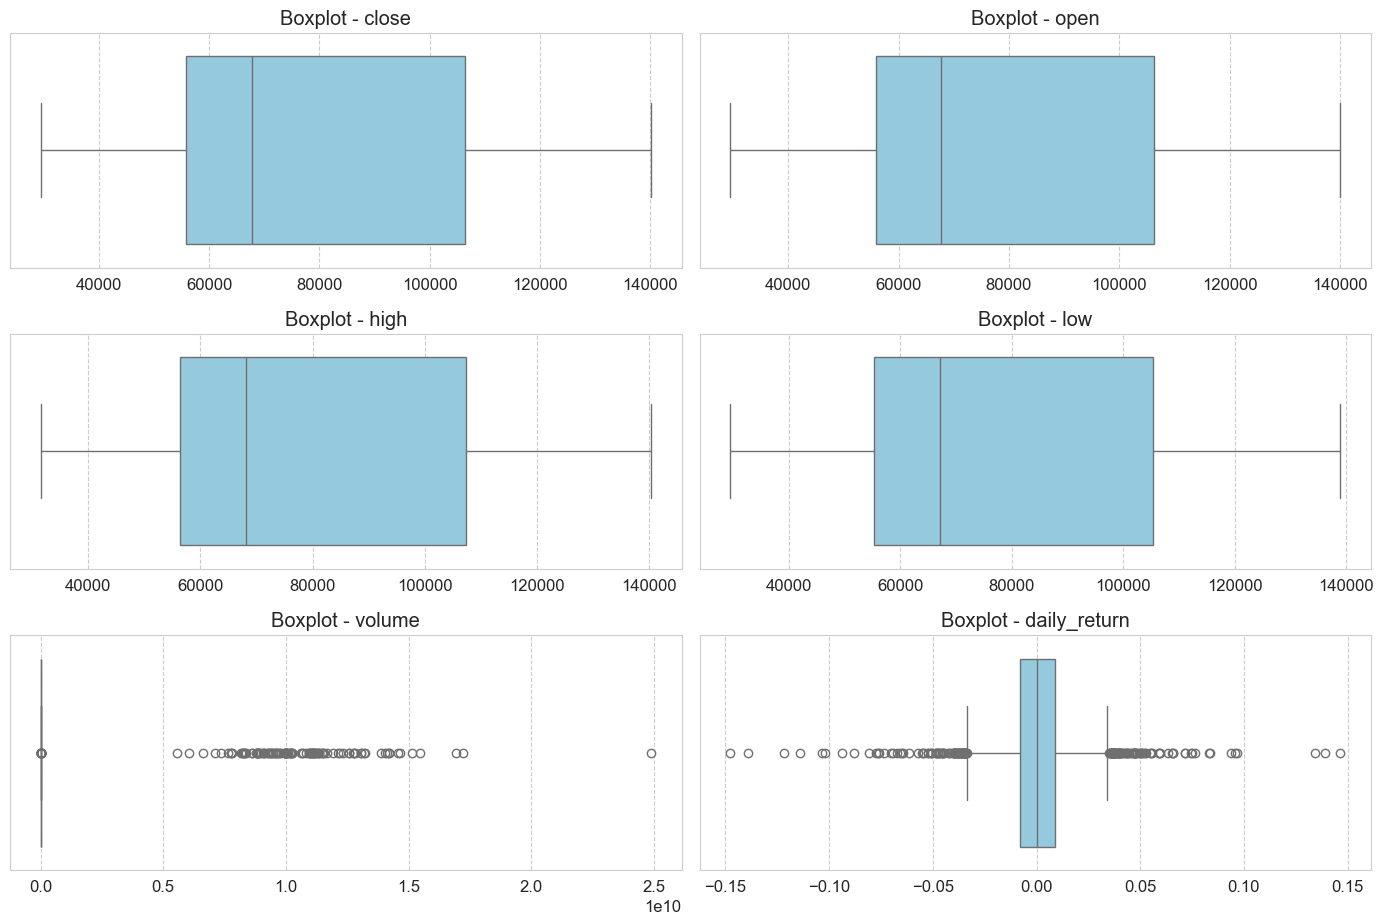

In [19]:
# Box Plots
colunas = df_2015_2025[['close', 'open', 'high', 'low', 'volume', 'daily_return']]

plt.figure(figsize=(14, 18))  # aumenta o tamanho para não ficar apertado

for i, coluna in enumerate(colunas, 1):
    plt.subplot(6, 2, i)
    sns.boxplot(x=df[coluna], color='skyblue')
    plt.title(f'Boxplot - {coluna}')
    plt.xlabel('')
    plt.tight_layout()

#### Tivemos uma distorção grande nos dados do volume,  devido a uma abrupta variação na média de negociação diária, a partir de 07 de Janeiro de 2025 até o momento, os valores negociados saltaram da casa de Milhões, que vinham sendo mostradas até essa data de 7 de Janeiro, para a casa de Bilhões a partir dessa data, distorcendo totalmente os dados prejudicando assim futuras análises que seriam feitas com o volume negociado.

#### Os gráficos abaixo monstram o tamanho da distorção devido a esse aumento de valores abrupto. Por causa dele não é possivel obter a leitura do periodo anterior ao início desse acontecimento, ao filtrar o periodo para o dia 01/01/2025 observamos que a movimentação do volume é normalizada.

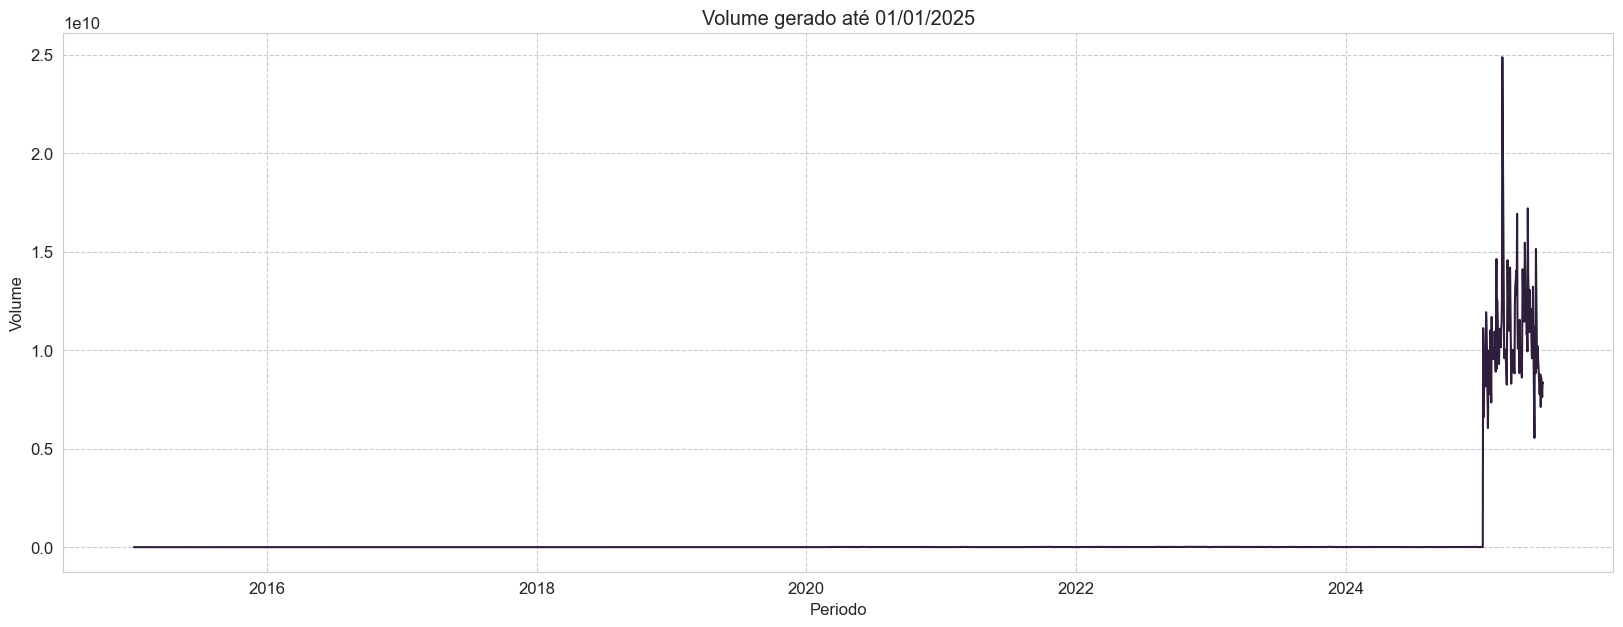

In [48]:
# # Gráfico do volume completo
sns.lineplot(df_2015_2025, x=df_2015_2025.index, y='volume',legend=True)
plt.title('Volume gerado até 01/01/2025')
plt.xlabel('Periodo')
plt.ylabel('Volume')
plt.show()

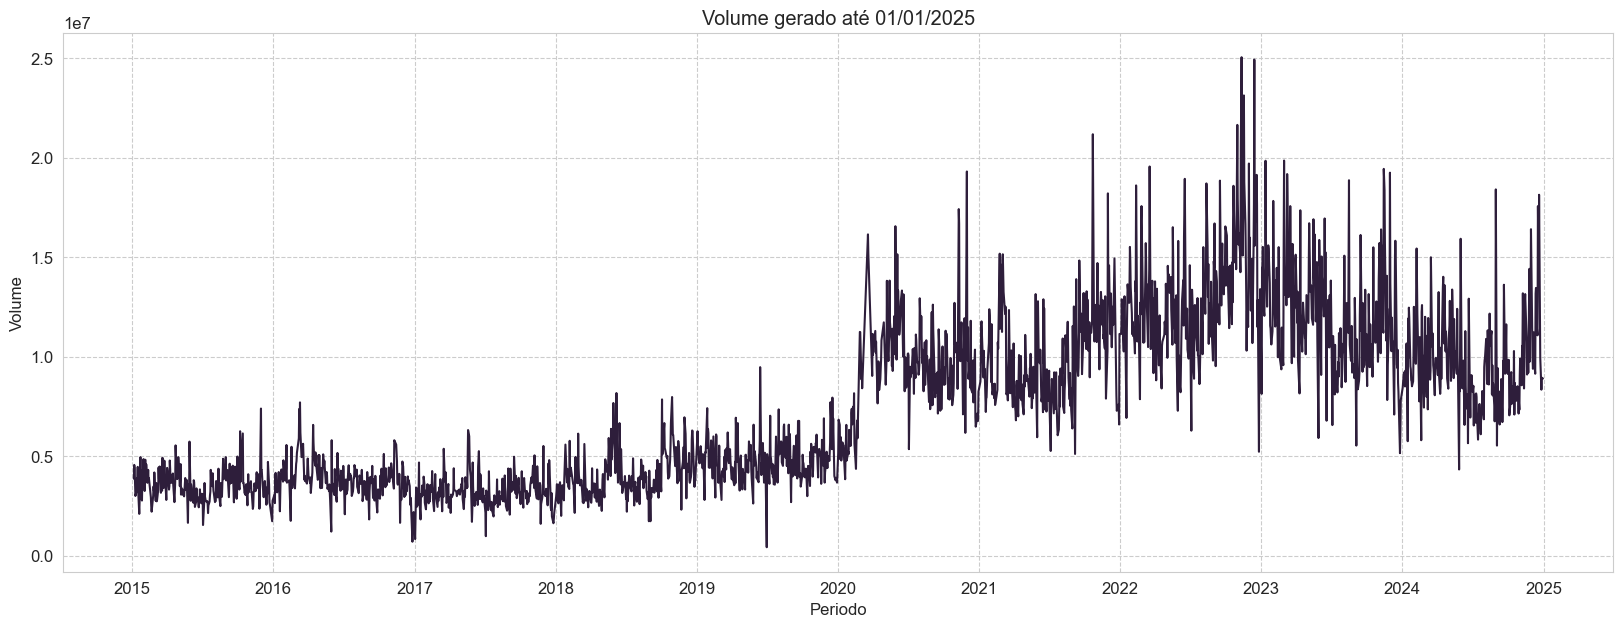

In [47]:
vol = df_2015_2025[df_2015_2025.index < '2025-01-01']
# Gráfico do volume com data até dia 01-01-2025

sns.lineplot(vol, x=vol.index, y='volume',legend=True)
plt.title('Volume gerado até 01/01/2025')
plt.xlabel('Periodo')
plt.ylabel('Volume')
plt.show()

In [20]:
# Z-Score e Intervalo Interquartil (IQR)

colunas = ['close', 'open', 'high', 'low', 'volume', 'daily_return']

for col in colunas:
    print(f'\n📌 Analisando a coluna: {col.upper()}')

    # === Z-SCORE ===
    df_2015_2025[f'z_score_{col}'] = zscore(df_2015_2025[col].dropna())  # evita erro com NaN
    outliers_z = df_2015_2025[(df_2015_2025[f'z_score_{col}'] > 3) | (df_2015_2025[f'z_score_{col}'] < -3)] # 3 vezes acima ou abaixo do desvio padrão
    print(f'🔹 Outliers (Z-Score): {len(outliers_z)}')
    print(outliers_z[[col, f'z_score_{col}']].head())

    # === IQR ===
    Q1 = df_2015_2025[col].quantile(0.25)
    Q3 = df_2015_2025[col].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR # valores abaixo de 1.5 vezes do Intervalo interquartil
    limite_superior = Q3 + 1.5 * IQR # valores acima de 1.5 vezes do Intervalo interquartil

    outliers_iqr = df_2015_2025[(df_2015_2025[col] < limite_inferior) | (df_2015_2025[col] > limite_superior)] # Efetua a condição para definir se é outlier ou não
    print(f'🔸 Outliers (IQR): {len(outliers_iqr)}')
    print(outliers_iqr[[col]].head())


📌 Analisando a coluna: CLOSE
🔹 Outliers (Z-Score): 0
Empty DataFrame
Columns: [close, z_score_close]
Index: []
🔸 Outliers (IQR): 0
Empty DataFrame
Columns: [close]
Index: []

📌 Analisando a coluna: OPEN
🔹 Outliers (Z-Score): 0
Empty DataFrame
Columns: [open, z_score_open]
Index: []
🔸 Outliers (IQR): 0
Empty DataFrame
Columns: [open]
Index: []

📌 Analisando a coluna: HIGH
🔹 Outliers (Z-Score): 0
Empty DataFrame
Columns: [high, z_score_high]
Index: []
🔸 Outliers (IQR): 0
Empty DataFrame
Columns: [high]
Index: []

📌 Analisando a coluna: LOW
🔹 Outliers (Z-Score): 0
Empty DataFrame
Columns: [low, z_score_low]
Index: []
🔸 Outliers (IQR): 0
Empty DataFrame
Columns: [low]
Index: []

📌 Analisando a coluna: VOLUME
🔹 Outliers (Z-Score): 108
                  volume  z_score_volume
ds                                      
2025-01-07  1.112000e+10        4.781699
2025-01-08  1.023000e+10        4.382193
2025-01-10  9.260000e+09        3.946776
2025-01-13  8.160000e+09        3.453005
2025-01-14  9

#### Devido a essa distorção significante, fizemos testes Z-SCORE e de Intervalo Interquartil, para observarmos quantos dados estão sendo considerados outliers, e assim definir o que poderá ser feito caso esses outliers venham a nos prejudicar em análises futuras, e quando formos utilizá-los nos modelos de Machine Learning.

In [49]:
(df_2015_2025)

,target,close,open,high,low,volume,daily_return
ds,,,,,,,
2015-01-05,0.0,47517,48512,48512,47264,3.870000e+06,-0.0205
2015-01-06,1.0,48001,47517,48061,47338,4.560000e+06,0.0102
2015-01-07,1.0,49463,48006,49882,48006,4.410000e+06,0.0305
2015-01-08,1.0,49943,49463,50261,49017,3.620000e+06,0.0097
2015-01-09,0.0,48840,49955,49955,48501,3.000000e+06,-0.0221
...,...,...,...,...,...,...,...
2025-06-12,1.0,137800,137127,137931,136175,7.120000e+09,0.0049
2025-06-13,0.0,137213,137800,137800,136586,8.630000e+09,-0.0043
2025-06-16,1.0,139256,137212,139988,137212,7.620000e+09,0.0149


In [52]:
print(f'Percentual de outlier de IRQ em relação ao df de analise: {round(len(outliers_iqr) / len(df_2015_2025) * 100, 2)}%')
print(f'Percentual de outlier de Z-SCORE em relação ao df de analise: {round(len(outliers_z) / len(df_2015_2025) * 100, 2)}%')
print(f'Percentual de outlier total em relação ao df de analise: {round((len(outliers_z) + len(outliers_iqr)) / len(df_2015_2025) * 100, 2)}%')

Percentual de outlier de IRQ em relação ao df de analise: 2.98%
Percentual de outlier de Z-SCORE em relação ao df de analise: 1.07%
Percentual de outlier total em relação ao df de analise: 4.05%


#### Obtivemos 4.05% de outliers, fazendo uma análise minuciosa dos dados, percebesse que esses outliers estão espalhados desde de 2015 até 2024 sendo que 1 dia em 2023 e 1 dia em 2024, sendo assim consideramos que a exclusão dos dados da coluna daily_return, que acreditamos não afetará nosso conjunto de dados para análises posteriores, e também para ser utilizado em nossos modelos.

#### Optamos por não utilizar os dados de volume devido a discrepância dada desde de 07 Janeiro de 2025, com um variação abrupta da casa de Milhões para Bilhões distorcendo completamente nossas análises.

In [ ]:
# Unir linhas de outliers a-score e IQR
indices_outliers = outliers_iqr.index.union(outliers_z.index)

# Remove linhas do DataFrame original
df_2015_2025 = df_2015_2025.drop(index=indices_outliers, axis=0).copy()
df_2015_2025 = df_2015_2025.drop(columns= ['z_score_close', 'z_score_open', 'z_score_high', 'z_score_low',
       'z_score_volume', 'z_score_daily_return']).copy()
df_2015_2025

,target,close,open,high,low,volume,daily_return
ds,,,,,,,
2015-01-05,0.0,47517,48512,48512,47264,3.870000e+06,-0.0205
2015-01-06,1.0,48001,47517,48061,47338,4.560000e+06,0.0102
2015-01-07,1.0,49463,48006,49882,48006,4.410000e+06,0.0305
2015-01-08,1.0,49943,49463,50261,49017,3.620000e+06,0.0097
2015-01-09,0.0,48840,49955,49955,48501,3.000000e+06,-0.0221
...,...,...,...,...,...,...,...
2025-06-12,1.0,137800,137127,137931,136175,7.120000e+09,0.0049
2025-06-13,0.0,137213,137800,137800,136586,8.630000e+09,-0.0043
2025-06-16,1.0,139256,137212,139988,137212,7.620000e+09,0.0149


## Análise Univariada

#### Teste de hipótese

O teste de Shapiro-Wilk é um teste de hipótese que verifica se uma amostra de dados segue uma distribuição normal.

* Hipótese Nula (H₀): A amostra provém de uma população com distribuição normal.
* Hipótese Alternativa (H₁): A amostra NÃO provém de uma população com distribuição normal.

Teste curtose, Assimétrico e D'Agostino.

* Curtose - Descrevendo a forma da cauda de uma distribuição normal para observar o quão pesadas ou leves são as extremidades em relação à média.
* Assimétrico - Observa a assimetria das caúdas, se menor que 0 assimetria a esquerda, se maior que 0 assimetria a direita e igual ou muito próximo de 0 simétrica.
* D'Agotino - Teste alternativo ao de normalidade, com o mesmo propósito, p_value < 0.05, a distribuição não é normal.


📊 Análise da coluna: close


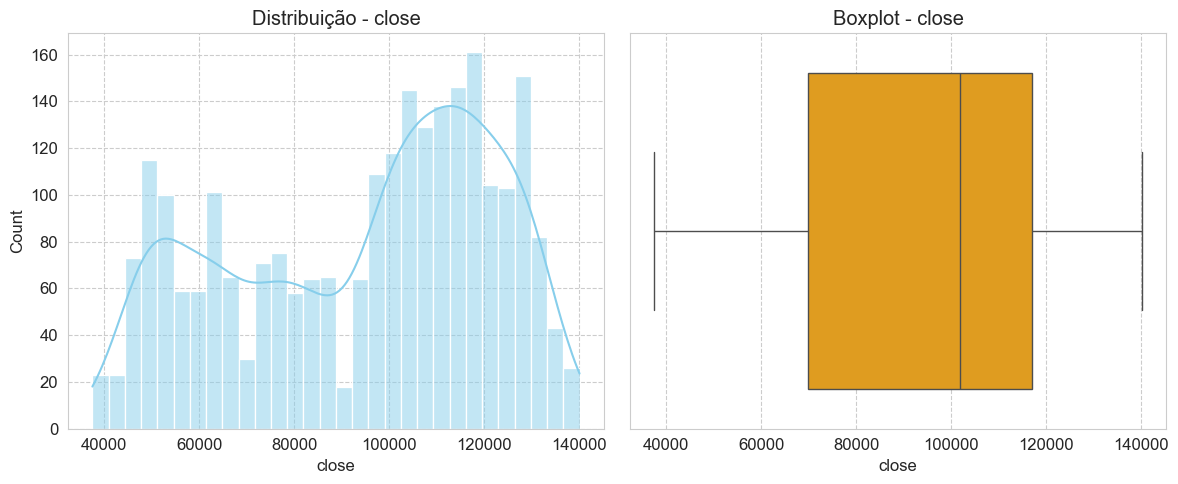

📈 Assimetria: -0.3884
📉 Curtose: -1.1320
🧪 Shapiro-Wilk p-valor: 0.0000 (não normal)
🧪 D’Agostino p-valor: 0.0000 (não normal)

📊 Análise da coluna: open


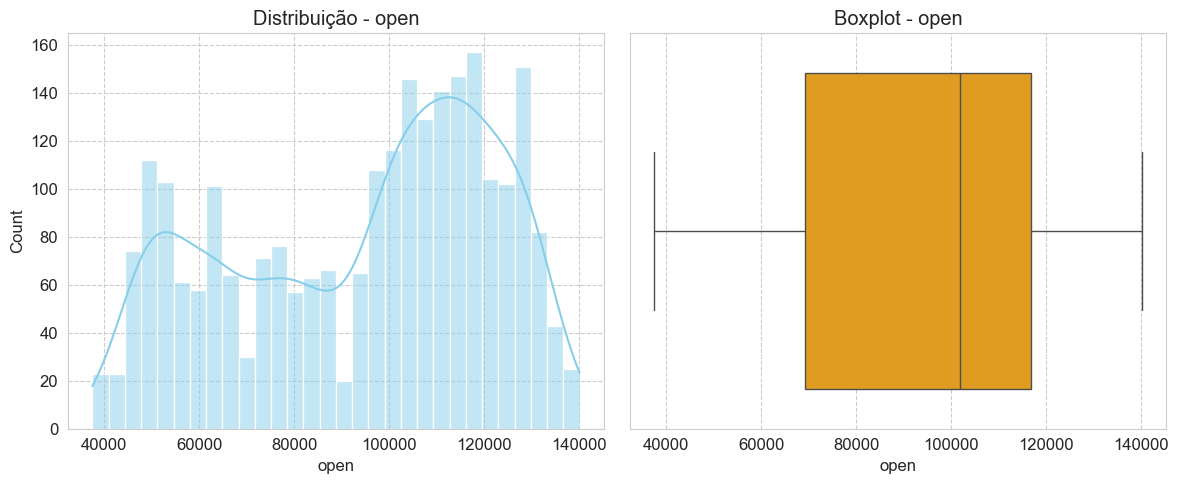

📈 Assimetria: -0.3860
📉 Curtose: -1.1347
🧪 Shapiro-Wilk p-valor: 0.0000 (não normal)
🧪 D’Agostino p-valor: 0.0000 (não normal)

📊 Análise da coluna: high


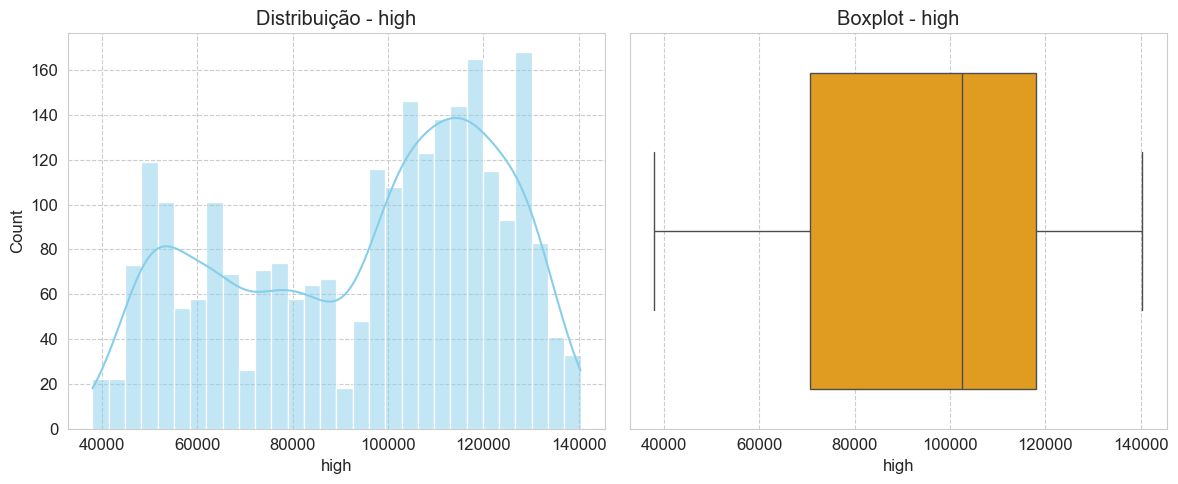

📈 Assimetria: -0.3953
📉 Curtose: -1.1350
🧪 Shapiro-Wilk p-valor: 0.0000 (não normal)
🧪 D’Agostino p-valor: 0.0000 (não normal)

📊 Análise da coluna: low


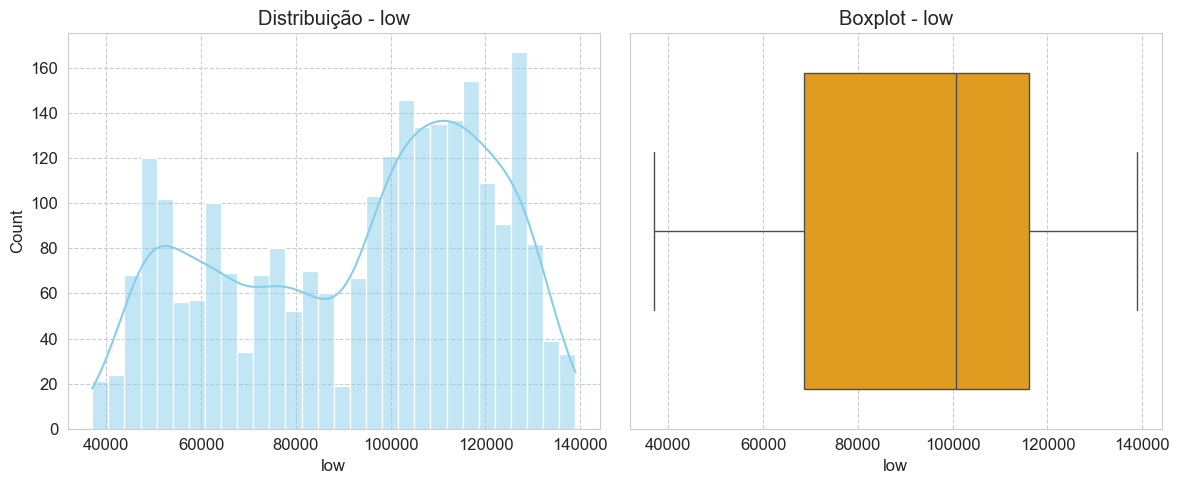

📈 Assimetria: -0.3795
📉 Curtose: -1.1313
🧪 Shapiro-Wilk p-valor: 0.0000 (não normal)
🧪 D’Agostino p-valor: 0.0000 (não normal)

📊 Análise da coluna: daily_return


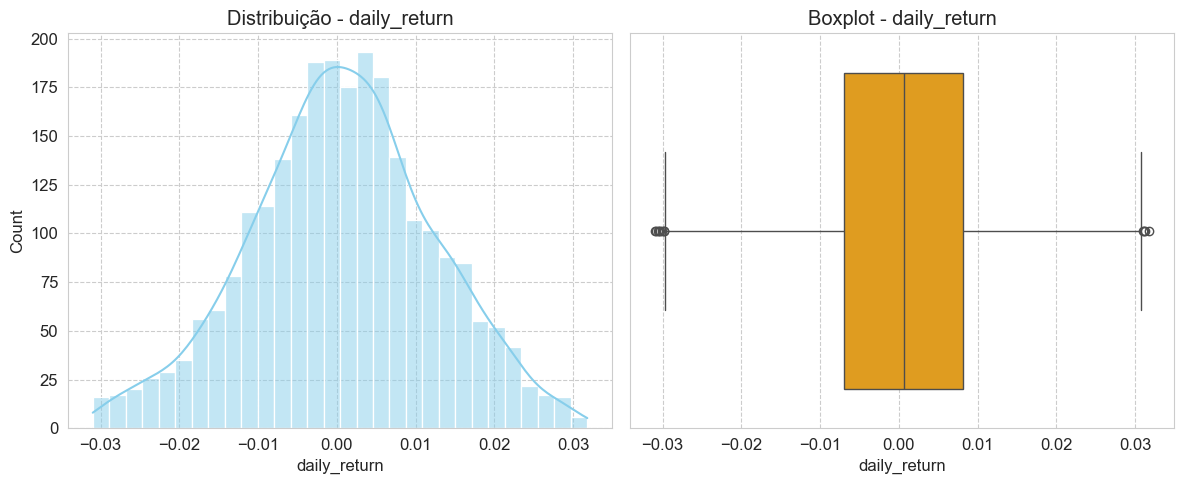

📈 Assimetria: -0.0658
📉 Curtose: -0.1359
🧪 Shapiro-Wilk p-valor: 0.2480 (normal)
🧪 D’Agostino p-valor: 0.1451 (normal)


In [23]:
colunas = ['close', 'open', 'high', 'low', 'daily_return']  # Altere conforme necessário

for coluna in colunas:
    print(f'\n📊 Análise da coluna: {coluna}')

    # Plot da distribuição
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.histplot(df_2015_2025[coluna], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribuição - {coluna}')

    plt.subplot(1, 2, 2)
    sns.boxplot(x=df_2015_2025[coluna], color='orange')
    plt.title(f'Boxplot - {coluna}')

    plt.tight_layout()
    plt.show()

    # Estatísticas
    assimetria = skew(df_2015_2025[coluna].dropna())
    curtose = kurtosis(df_2015_2025[coluna].dropna(), fisher=True)
    stat_shapiro, p_shapiro = shapiro(df_2015_2025[coluna].dropna().sample(n=500) if df_2015_2025[coluna].dropna().shape[0] > 500 else df_2015_2025[coluna].dropna())
    stat_dagostino, p_dagostino = normaltest(df_2015_2025[coluna].dropna())

    print(f'📈 Assimetria: {assimetria:.4f}') # Observar se a cauda da direita é > 0 - a da esquerda é < 0 e se for igual a 0 é simátrica 
    print(f'📉 Curtose: {curtose:.4f}') # 
    print(f'🧪 Shapiro-Wilk p-valor: {p_shapiro:.4f} {"(não normal)" if p_shapiro < 0.05 else "(normal)"}') # Teste de normalidade p < 0.05 -> não é normal
    print(f'🧪 D’Agostino p-valor: {p_dagostino:.4f} {"(não normal)" if p_dagostino < 0.05 else "(normal)"}') # Teste alternativo de normalidade p < 0.05 -> não é normal


#### Ao Remover os outliers da variação diária, conseguimos alcançar uma distribuição normal dos dados.

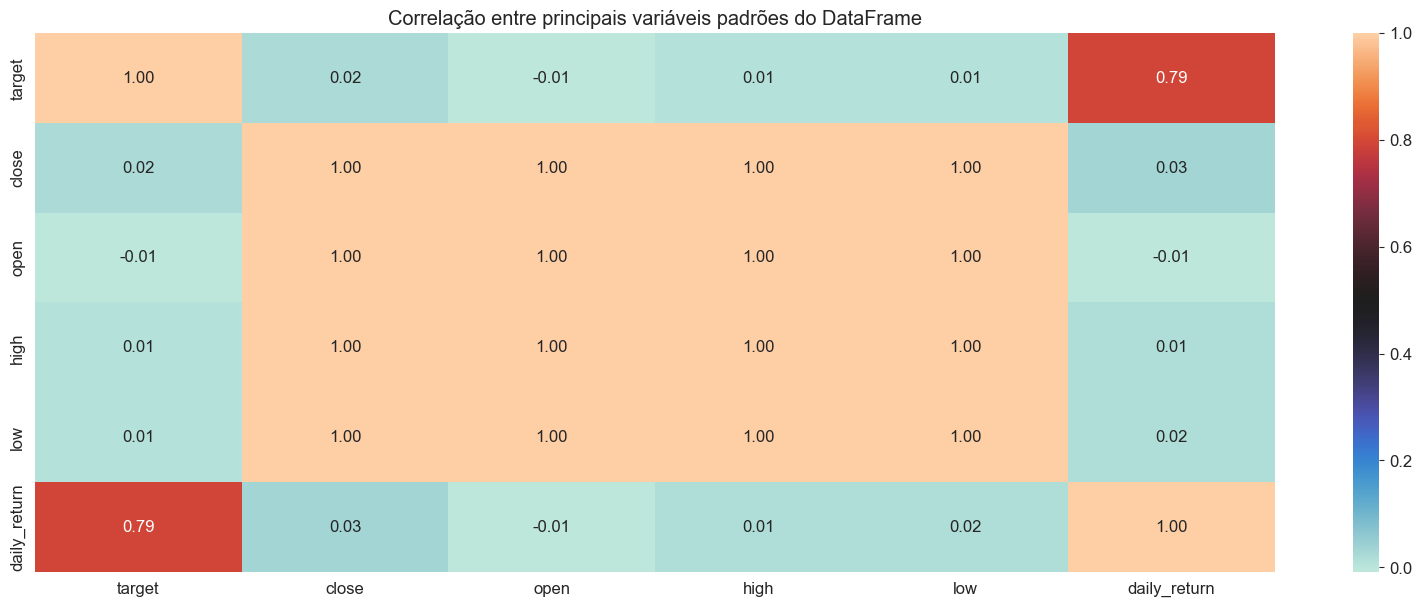

In [ ]:
# Gerando Gráfico de correlação
corr = df_2015_2025[['target','close', 'open', 'high', 'low', 'daily_return']].corr(numeric_only=True)

sns.heatmap(corr, annot=True, fmt='.2f', center= 0.5)
plt.title('Correlação entre principais variáveis padrões do DataFrame')
plt.show()

#### Observando a correlação entre as co-váriaveis e nossa variável resposta, percebemos não ter correlação significante para uma escolha de co-variáveis, que serão utilizadas em nossos modelos de Machine Learning, com a função de prever o fechamento positivo ou negativo do dia D+1 (dia seguinte ao vigente).  

# Avaliação da Serie temporal dos dados originais.

In [26]:
# Decompor série temporal
annual_period = 252 # ano do pregão
df_decomposed = seasonal_decompose(df_2015_2025['close'], model='multiplicative', period=annual_period)

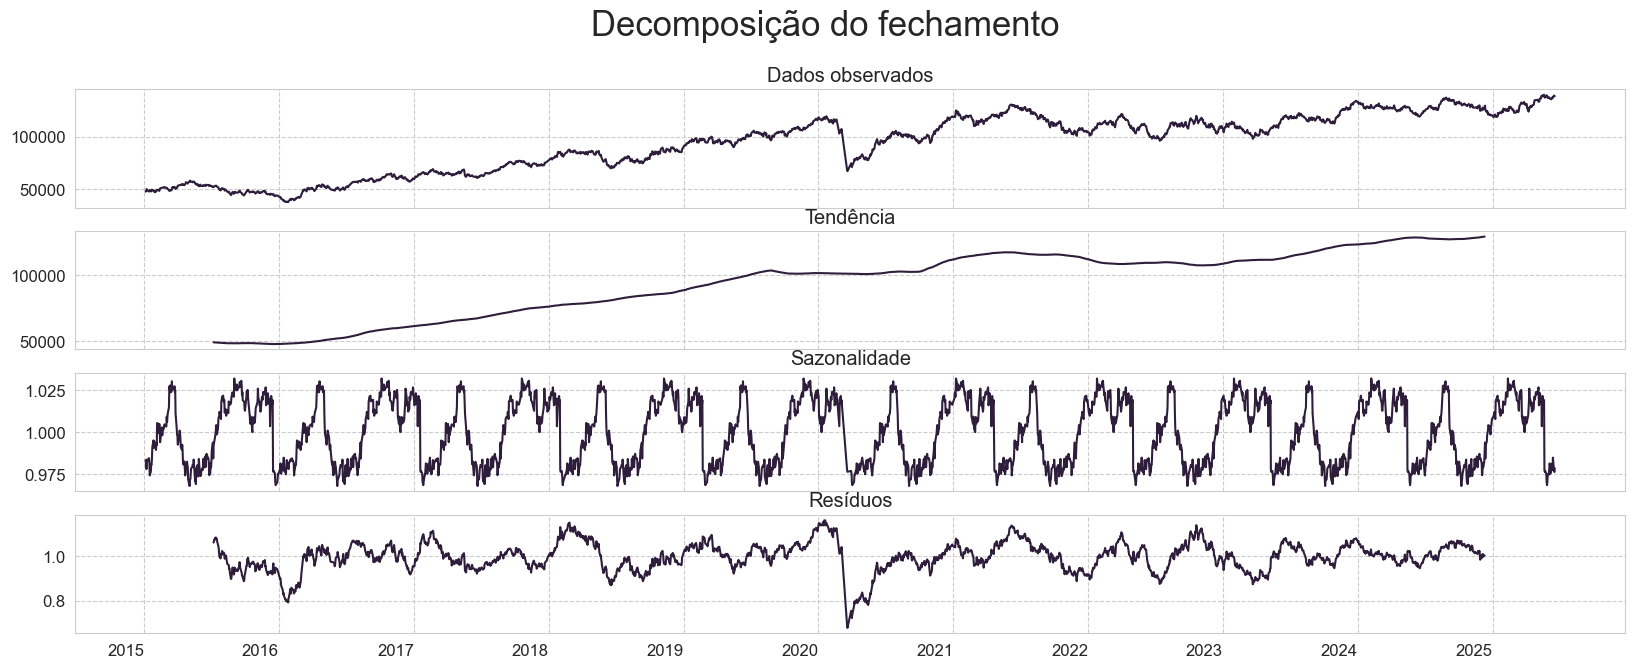

In [27]:
fig, axes = plt.subplots(4, 1, sharex=True,figsize = (20, 8))

df_decomposed.observed.plot(ax = axes[0], title = 'Dados observados')
df_decomposed.trend.plot(ax = axes[1], title = 'Tendência')
df_decomposed.seasonal.plot(ax = axes[2], title = 'Sazonalidade')
df_decomposed.resid.plot(ax = axes[3], title = 'Resíduos')

# Título e rótulos dos eixos
fig.suptitle('Decomposição do fechamento')
axes[0].xaxis.set_major_locator(mdates.YearLocator(base=1))
plt.xlabel('')
plt.xticks(rotation='horizontal')

plt.show()

#### Como visto no gráfico de decomposição, observamos que o índice IBOVESPA possui visivelmente uma tendência de alta que é logo confirmada pela decomposição TENDÊNCIA, retirando a sazonalidade e o ruido, o IBOVESPA também possui uma sazonalidade bem estruturada e constante durante esse periodo de 2015 à 2025, e por fim os residuos que são as partes que não são possiveis de serem explicadas no gráfico, como foram removidos padrões de tendência e sazonalidade dos dados.

#### Estacionaridade

Vamos observar quais dados das duas colunas (close) e (daily_return) possui ou não estacionaridade.

O teste ADF (Augmented Dickey-Fuller) verifica se a série é estacionaria, ou seja, como as propriedades mudam ao longo do tempo.

* Hipótese Nula (H₀): A série NÃO é estacionária (ela possui uma raiz unitária).
* Hipótese Alternativa (H₁): A série É estacionária (ela não possui uma raiz unitária).

In [29]:
# Cria função estacionario
def estacionario(series):

    adf = adfuller(series)
    print(f'Valor-p do Teste ADF: {adf[1]}')

    # Nível de significância de 95%
    if adf[1] > 0.05:
        print('Não rejeitar a hipótese nula: a série NÃO é estacionária')
    else:
        print('Rejeitar a hipótese nula: a série é estacionária')

In [ ]:
# Testa dados de fechamento e variação diária
# Fechamento
print('Fechamento')
estacionario(df['close'].values)

print('--------')

# Retorno diário
print('Retorno diário')
estacionario(df['daily_return'].values)

Fechamento
Valor-p do Teste ADF: 0.8539703036576209
Não rejeitar a hipótese nula: a série NÃO é estacionária
--------
Retorno diário
Valor-p do Teste ADF: 0.0
Rejeitar a hipótese nula: a série é estacionária


#### Para modelos de Machine Learning de regressão, podemos utilizar a daily_return como nossa variável resposta, porque ela já está estacionária, e assim as relações de aprendizagem entre as features, e ela poderá obter mais chances de se manterem válidas no futuro.  
#### Agora caso for necessário utilizar modelos especificos de supervisão de séries temporais, que foram explicitamente projetadas para lidar com dados não-estacionários podemos utilizar o fechamento como variável resposta.

In [31]:
# transforma o close em estacionário
print('Fechamento diferenciado 1x')
estacionario(df['close'].diff().dropna().values)

Fechamento diferenciado 1x
Valor-p do Teste ADF: 0.0
Rejeitar a hipótese nula: a série é estacionária


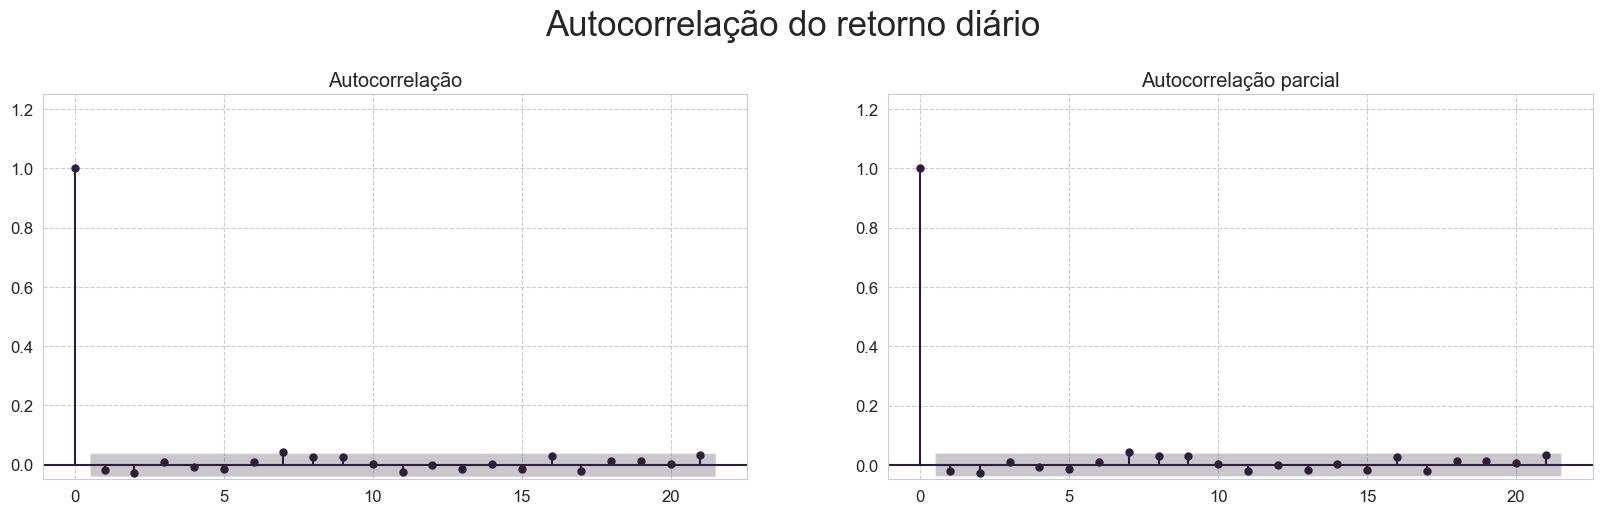

In [ ]:
# Gráfico de AUTOCORRELAÇÃO
fig, axes = plt.subplots(1, 2, figsize = (20,5))

plot_acf(df_2015_2025['daily_return'], lags = 21, title = 'Autocorrelação', auto_ylims = True, ax = axes[0])
plot_pacf(df_2015_2025['daily_return'], lags = 21, title = 'Autocorrelação parcial', auto_ylims = True, ax = axes[1])
plt.suptitle('Autocorrelação do retorno diário', y=1.05)
plt.show()

#### O gráfico de alto correlação ACF e PACF nos índica que fora o lag 1 que é normal essa alta correlação, porque ele fazcorrelação com ele mesmo, o restante das correlações dentro do nível de confiança de 95%, não tem correlação significativa, nos mostrando que os retornos parecem ser independentes no tempo. Isso é comum em mercado financeiro, pois os preços tendem a seguir um passeio aleatório.

# Conclusão: 
#### Por esse motivo após uma análise minuciosa de nossos dados, chegamos a conclusão que só os dados pertencentes ao dataframe original não são suficientes, para que possam juntos aos modelos, nos trazerem predições satisfatórias e reais, e também retorno de previsão positiva, que esteja de acordo com nossa meta de score solicitado no desáfio.